# Change points detection algorithm
- From MoSeq
- Basseville, M., and Nikiforov, I.V. (1993). Detection of abrupt changes (Prentice-Hall Publishing).

In [1]:
""" 
IMPORTS
"""
import os
import autograd.numpy as np
import pickle
import seaborn as sns
from collections import defaultdict
import pandas as pd
import matplotlib.pyplot as plt

# --Machine learning and statistics+
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, Normalizer
from scipy.ndimage import gaussian_filter1d
from scipy.signal import argrelextrema

from one.api import ONE
one = ONE()


## Parameters

In [2]:
bin_size = 0.1

data_path_v1 =  '/home/ines/repositories/representation_learning_variability/DATA/Sub-trial/Design matrix/' + 'v1/' + str(bin_size) + '/'
data_path_v2 =  '/home/ines/repositories/representation_learning_variability/DATA/Sub-trial/Design matrix/' + 'v2_3Nov2023/' + str(bin_size) + '/'
#data_path_v2 =  '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/DATA/Sub-trial/Design matrix/' + 'v2_3Nov2023/' + str(bin_size) + '/'

data_path = data_path_v2

os.chdir(data_path)
design_matrices = os.listdir(data_path)

if data_path == data_path_v1:
       var_names = ['avg_wheel_vel', 'pupil_diameter',
              'whisker_me', 'nose_speed_X', 'nose_speed_Y', 
              'l_paw_speed_X', 'l_paw_speed_Y', 'pupil_speed_X',
              'pupil_speed_Y', 'Gaussian_licks']
elif data_path == data_path_v2:
       var_names = ['avg_wheel_vel', 'pupil_diameter',
              'whisker_me', 'nose_speed', 'l_paw_speed', 'left_X', 'left_Y',
              'pupil_speed', 'pupil_X', 'pupil_Y', 'Lick count']

# Plotting params
multiplier = 1/bin_size

event_type_list = ['goCueTrigger_times']  # , 'feedback_times', 'firstMovement_times'
event_type_name = ['Go cue']  # , 'Feedback time', 'First movement onset'

## Preprocess list of design matrices

In [25]:
# Save data of all sessions for latter
matrix_all = defaultdict(list)
matrix_all_unnorm = defaultdict(list)
session_all = defaultdict(list)

for m, mat in enumerate(design_matrices[0:1]):
    
    # Trials data
    session = design_matrices[m][14:-4]
    
    #session = '2e6e179c-fccc-4e8f-9448-ce5b6858a183'
    #mat = 'design_matrix_2e6e179c-fccc-4e8f-9448-ce5b6858a183_0.1new_version'
    
    session_trials = one.load_object(session, obj='trials', namespace='ibl')
    session_trials = session_trials.to_df()
    session_end = list(session_trials['stimOff_times'][-1:])[0]  # TODO: this might not work if stimOff times are missing
    session_start = list(session_trials['stimOn_times'])[0]
    
    big_design_matrix = pickle.load(open(mat, "rb"))
    
    design_matrix = big_design_matrix.groupby('Bin')[var_names].mean()  # 
    design_matrix = design_matrix.reset_index(level = [0])  # , 'Onset times'
    design_matrix = design_matrix.dropna()
    
    # Trim design matrix to be as long as the session (otherwise it will include task-unrelated behavior)
    design_matrix = design_matrix.loc[(design_matrix['Bin'] < session_end * 10) & (design_matrix['Bin'] > session_start * 10)]
    training_set = np.array(design_matrix[var_names]).copy() 
    
    if len(training_set) > 0:
      # Standardization using StandardScaler
      scaler = StandardScaler()
      standardized = scaler.fit_transform(training_set)
      # Normalize between 0 and 1
      normalizer = Normalizer().fit(standardized)
      normalized = normalizer.transform(standardized)
      
    # Save results
    matrix_all[mat].append(normalized)
    session_all[mat].append(session_trials)    
    matrix_all_unnorm[mat].append(design_matrix) 

In [26]:
use_data = design_matrix[var_names].copy()  # To keep the column names
use_data[var_names] = matrix_all[mat][0]

### Parameters
Need to do grid-search on this

In [51]:
k = 4  # bin lag for derivative calculation
h = 01.5  # thresold??
sigma = 0.43  # for Gaussian filter

k = 2
h = 0.5
sigma = 0.7

### Derivative

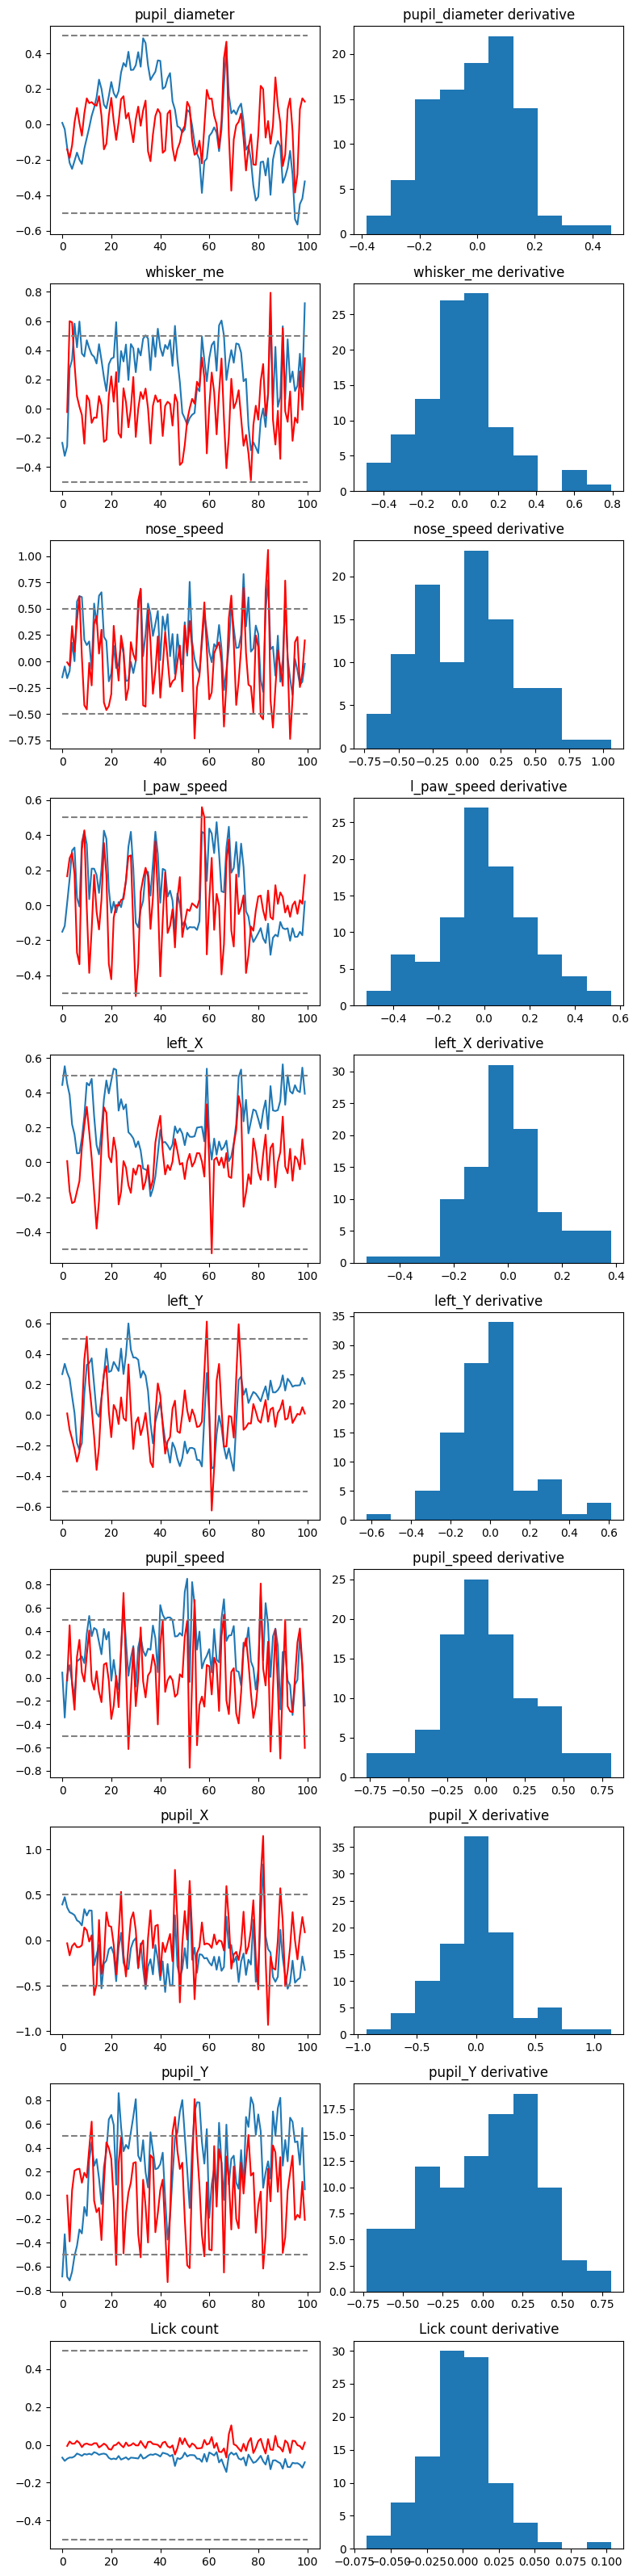

In [52]:
derivative = use_data.copy()

features = use_data.keys()[1:]

min = 0
max = 100

fig, ax = plt.subplots(nrows=len(features) , ncols=2, sharex=False, sharey=False, figsize=[8, 32])

for i, feat in enumerate(features):
    derivative[feat] = derivative[feat] - derivative[feat].shift(k)    
    
    ax[i, 0].plot(use_data[feat][min:max])
    ax[i, 0].plot(derivative[feat][min:max], color='red')
    ax[i, 0].hlines(h, min, max, linestyles='--', color='Gray')
    ax[i, 0].hlines(-h, min, max, linestyles='--', color='Gray')
    ax[i, 1].hist(derivative[feat][min:max])
    ax[i, 0].set_title(feat)
    ax[i, 1].set_title(str(feat + ' derivative'))

plt.tight_layout()


### Thresholding

In [54]:
thresholded = derivative[np.array(features)]

for i, feat in enumerate(features):
    # thresholded[pc] = thresholded[pc] * np.nan
    thresholded.loc[(thresholded[feat] >= -h) & (thresholded[feat] <= h), feat] = 0
    thresholded.loc[thresholded[feat] > h, feat] = 1
    thresholded.loc[thresholded[feat] < -h, feat] = 1

summed_threshold = np.sum(thresholded, axis=1)
# overall_thresold = np.array(summed_threshold)
# overall_thresold[np.where(summed_thresold>=5)] = 1
# overall_thresold[np.where(summed_thresold<5)] = 0

/tmp/ipykernel_21745/1722447556.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thresholded.loc[(thresholded[feat] >= -h) & (thresholded[feat] <= h), feat] = 0
/tmp/ipykernel_21745/1722447556.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thresholded.loc[thresholded[feat] > h, feat] = 1
/tmp/ipykernel_21745/1722447556.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thresholded.loc[thresholded[feat] < -h, feat] = 1


### Gaussian filter

In [55]:
# Apply Gaussian filter
# smoothed_signal = gaussian_filter1d(overall_thresold, sigma=sigma)
smoothed_signal = gaussian_filter1d(summed_threshold, sigma=sigma)

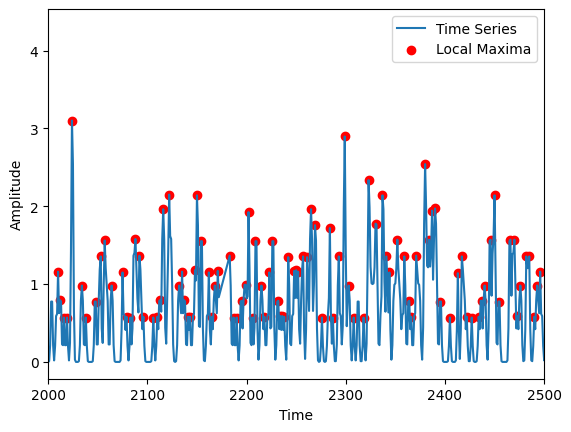

In [57]:
local_maxima = argrelextrema(smoothed_signal, np.greater)

time = design_matrix['Bin']
# Plot the time series and local maxima
plt.plot(time, smoothed_signal, label='Time Series')
plt.scatter(time[local_maxima[0]], smoothed_signal[local_maxima[0]], color='red', label='Local Maxima')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.xlim([2000, 2500])
plt.show()

### Control data

In [59]:
shuffled_data = use_data.copy()
shuffled_data = shuffled_data.sample(frac=1).reset_index(drop=True)

#shuffled_data = shuffled_data.sample(frac=1, axis=0).sample(frac=1, axis=1)

### Grid serach

In [77]:
def changepoint_detection(data, k, h1, h2, sigma):

    # Initialize
    derivative = data.copy()
    thresholded = derivative.copy()

    # Find first derivative and threshold
    features = data.keys()[1:]
    for i, feat in enumerate(features):
        derivative[feat] = derivative[feat] - derivative[feat].shift(k)    
    
        # Thresold derivative
        thresholded.loc[(thresholded[feat] >= -h) & (thresholded[feat] <= h), feat] = 0
        thresholded.loc[thresholded[feat] >= h, feat] = 1
        thresholded.loc[thresholded[feat] <= -h, feat] = 1
    
    # Sum ove thresholded data
    summed_threshold = np.sum(thresholded, axis=1)
    # Apply Gaussian filter
    smoothed_signal = gaussian_filter1d(summed_threshold, sigma=sigma)
    
    # Detect local maxima
    local_maxima = argrelextrema(smoothed_signal, np.greater)
    
    # Keep local maxima is above a threshold
    crit = smoothed_signal[local_maxima[0]] > 1
    changepoints = local_maxima[0][crit]
    
    return changepoints, smoothed_signal

In [71]:
sigma = 0.9
k = 2
h1 = .5
h2 = 1

In [83]:
ks = [2, 3, 4, 5, 6]  # bin lag for derivative calculation
ks = [2, 3, 4, 5, 6]
hs1 = [0.1, 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 1, 1.4, 1.5, 1.6, 1.7, 2, 2.5, 2.9, 3, 3.2, 3.5, 4, 4.5]  # thresold??
hs2 = [0.1, 0.2, 0.5, 0.6, 0.7, 1, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2, 2.1, 2.2, 2.3, 2.5, 2.9, 3, 3.2, 3.5, 4, 5]  # thresold??
sigmas = [0.3, 0.43, 0.5, 0.6, 0.65, 0.7, 0.75, 0.8, 0.81, 0.82, 0.83, 0.85, 0.9, 0.95, 1, 2, 3, 4, 5]  # for Gaussian filter

results_data = {}
smoothed_data = {}
results_control ={}
summary_results = {}

features = use_data.keys()[1:]

# Shuffle the data
shuffled_data = use_data.copy()
shuffled_data = shuffled_data.sample(frac=1).reset_index(drop=True)  # Shuffle columns as well
shuffled_data[np.array(features)] = shuffled_data[np.array(features)].sample(frac=1, axis=0).sample(frac=1, axis=1)  # Shuffle both rows and columns

for ik, k in enumerate(ks):
    results_data[k] = {}
    smoothed_data[k] = {}
    results_control[k] = {}
    summary_results[k] = {}
    
    for ih, h1 in enumerate(hs1):
        results_data[k][h1] = {}
        smoothed_data[k][h1] = {}
        results_control[k][h1] = {}
        summary_results[k][h1] = {}

        for ih, h2 in enumerate(hs2):
            results_data[k][h1][h2] = {}
            smoothed_data[k][h1][h2] = {}
            results_control[k][h1][h2] = {}
            summary_results[k][h1][h2] = {}
        
            for isig, sigma in enumerate(sigmas):
            
                """ Data """
                data_changepoints, smoothed_signal = changepoint_detection(use_data, k, h1, h2, sigma)
                
                """ Control """
                shuffled_changepoints, _ = changepoint_detection(shuffled_data, k, h1, h2, sigma)
                
                """ Save results """
                results_data[k][h1][h2][sigma] = data_changepoints 
                smoothed_data[k][h1][h2][sigma] = smoothed_signal
                results_control[k][h1][h2][sigma] = shuffled_changepoints 
                summary_results[k][h1][h2][sigma] = [len(data_changepoints), len(shuffled_changepoints)]


KeyboardInterrupt: 

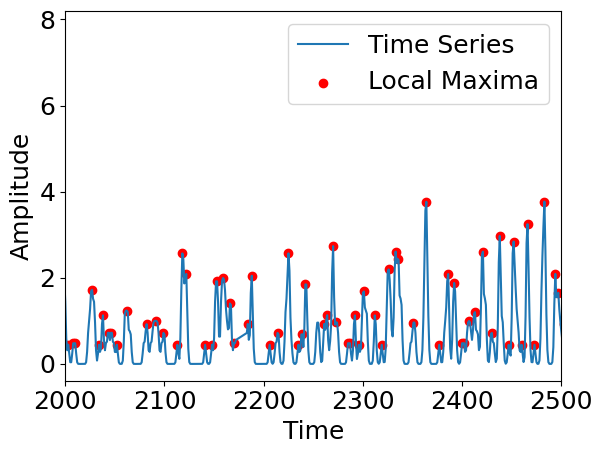

In [ ]:
local_maxima = argrelextrema(smoothed_signal, np.greater)

time = design_matrix['Bin']
# Plot the time series and local maxima
plt.plot(time, smoothed_signal, label='Time Series')
plt.scatter(time[local_maxima[0]], smoothed_signal[local_maxima[0]], color='red', label='Local Maxima')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.xlim([2000, 2500])
plt.show()

In [101]:
expected_lag = 10
threshold = len(smoothed_signal)/(10*expected_lag)  # Allow for shuffled data to detect changepoints around once every 100 sec

max_changepoints = []
keys = []
for ik, k in enumerate(ks):
    
    for ih, h in enumerate(hs):
    
        for isig, sigma in enumerate(sigmas):
                #if summary_results[k][h][sigma][1] == 0:
            if summary_results[k][h][sigma][1] <= threshold:

                if len(max_changepoints) == 0:
                    max_changepoints = [summary_results[k][h][sigma][0]]
                    keys = [k, h, sigma]
                else:
                    max_changepoints = np.vstack((max_changepoints, summary_results[k][h][sigma][0]))
                    keys = np.vstack((keys, [k, h, sigma]))


In [102]:
flat_changepoints = max_changepoints.ravel()
use_keys = keys[flat_changepoints==np.max(flat_changepoints)]
use_keys

AttributeError: 'list' object has no attribute 'ravel'

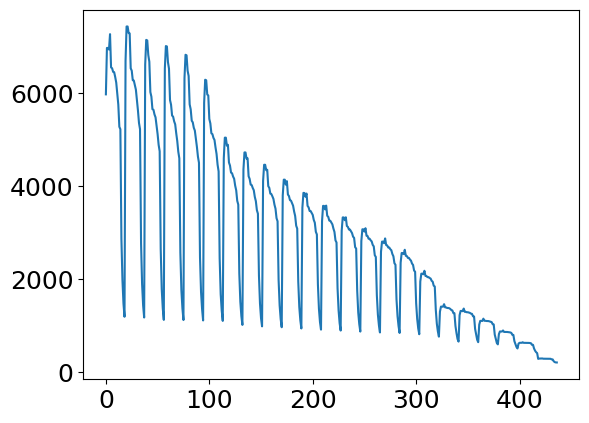

In [ ]:
plt.plot(max_changepoints)

### Optimal changepoints

In [91]:
sigma1 = 0.7
sigma2 = 0.8
k = 2
h = 3

k = int(use_keys[0][0])
h = float(use_keys[0][1])
sigma = float(use_keys[0][2])

data_changepoints, smoothed_signal = changepoint_detection(augmented_data, k, h, sigma)
shuffled_changepoints, _ = changepoint_detection(shuffled_data, k, h, sigma)

/tmp/ipykernel_8737/3178427875.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  derivative[pc] = derivative[pc] - derivative[pc].shift(k)
/tmp/ipykernel_8737/3178427875.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  derivative[pc] = derivative[pc] - derivative[pc].shift(k)


In [92]:
np.max(smoothed_signal)

10.000000000000002

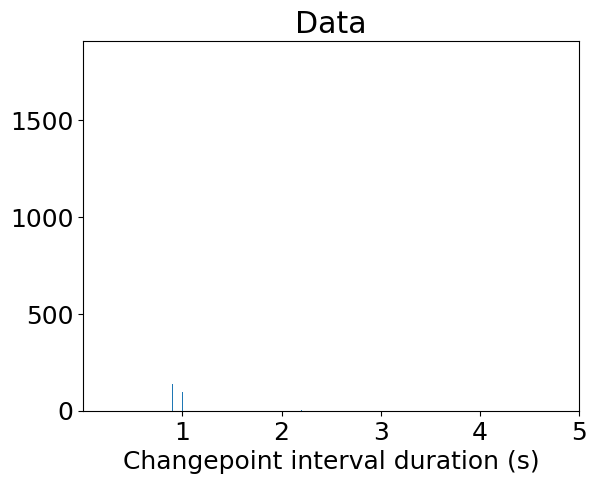

4.0
nan


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


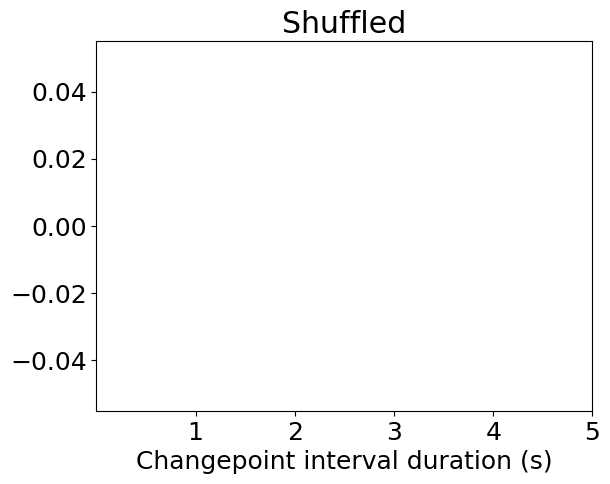

In [93]:
plt.hist(np.diff(data_changepoints[0]), bins=5000)
plt.xlim([0, 50])
plt.xlabel('Changepoint interval duration (s)')
plt.xticks([10, 20, 30, 40, 50], [1, 2, 3, 4, 5])
plt.title('Data')
plt.show()

plt.hist(np.diff(shuffled_changepoints[0]), bins=5000)
plt.xlim([0, 50])
plt.xlabel('Changepoint interval duration (s)')
plt.xticks([10, 20, 30, 40, 50], [1, 2, 3, 4, 5])
plt.title('Shuffled')

print(np.median(np.diff(data_changepoints[0])))
print(np.median(np.diff(shuffled_changepoints[0])))


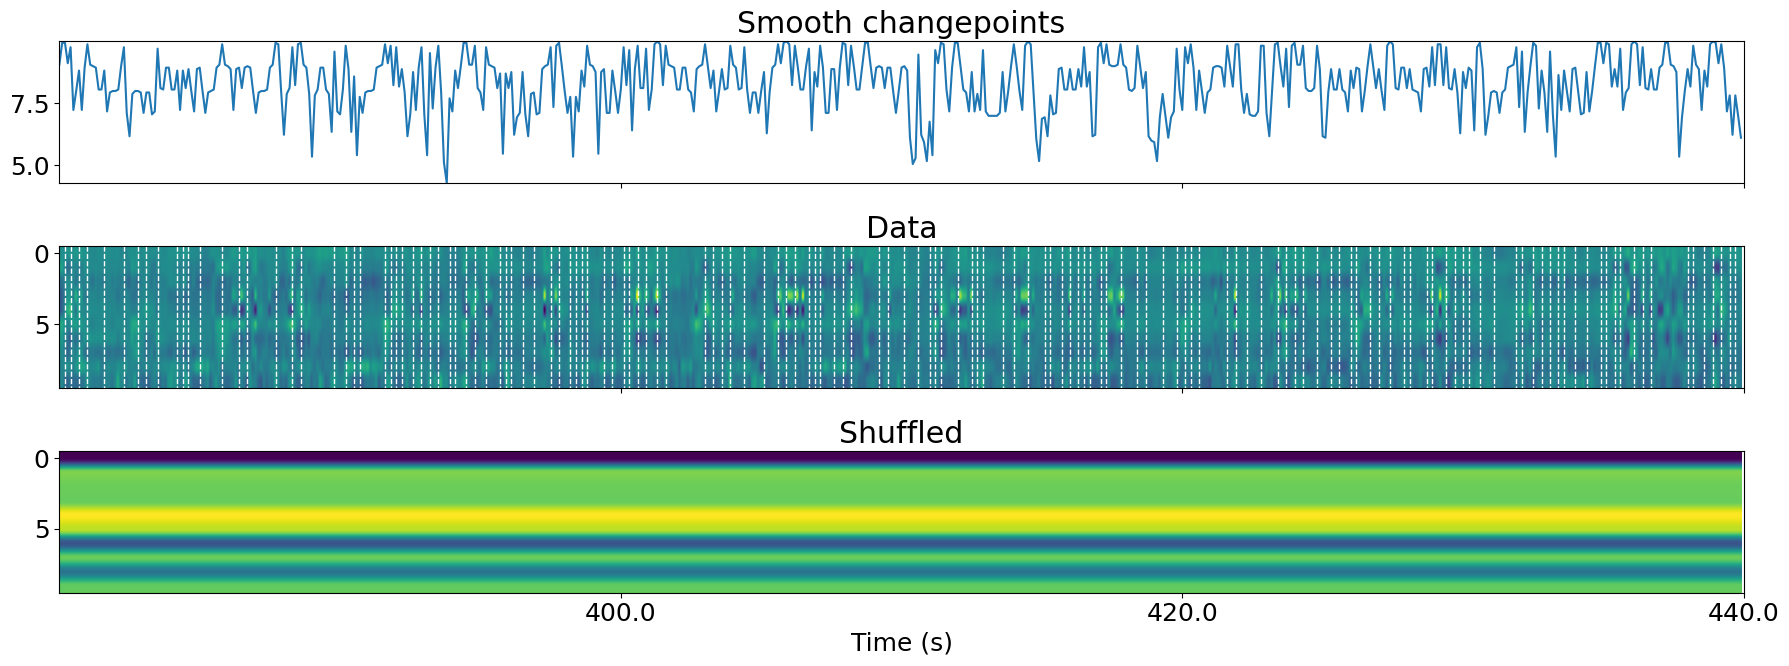

In [94]:
fig, ax = plt.subplots(nrows=3 , ncols=1, sharex=True, sharey=False, figsize=[18, 7])

interval = 600
init = 4000
end = init + interval

matrix = np.array(augmented_data[np.array(pcs)]).transpose()
shuf_matrix = np.array(shuffled_data[np.array(pcs)]).transpose()
vlines_data = data_changepoints[0] - init
vlines_shuf = shuffled_changepoints[0] - init

# Plot the data matrix
ax[0].plot(smoothed_signal[init:end])
ax[0].set_title('Smooth changepoints')
ax[0].set_ylim([np.min(smoothed_signal[init:end]), np.max(smoothed_signal[init:end])])

# Plot the data matrix
im1 = ax[1].imshow(matrix[:, init:end], aspect='auto')
ax[1].vlines(vlines_data, -0.5, 9.5, color='white', linewidth=1, linestyles='--')
ax[1].set_title('Data')

# Plot the control matrix
im2 = ax[2].imshow(shuf_matrix[:, init:end], aspect='auto')
ax[2].vlines(vlines_shuf, -0.5, 9.5, color='white', linewidth=1, linestyles='--')
ax[2].set_xlabel('Time (s)')
ax[2].set_xlim([0, interval])
ax[2].set_title('Shuffled')
# labels = [init/10 , init/10+20, init/10+40, init/10+60, init/10+80]
# ax[2].set_xticks([200, 400, 600, 800, 1000], labels)
labels = [init/10 , init/10+20, init/10+40]
ax[2].set_xticks([200, 400, 600], labels)
#ax[2].set_xticks([100, 200, 300], labels)

plt.tight_layout()

## Add colorbar
#cbar1 = fig.colorbar(im1, ax=ax[1])
#cbar2 = fig.colorbar(im2, ax=ax[2])


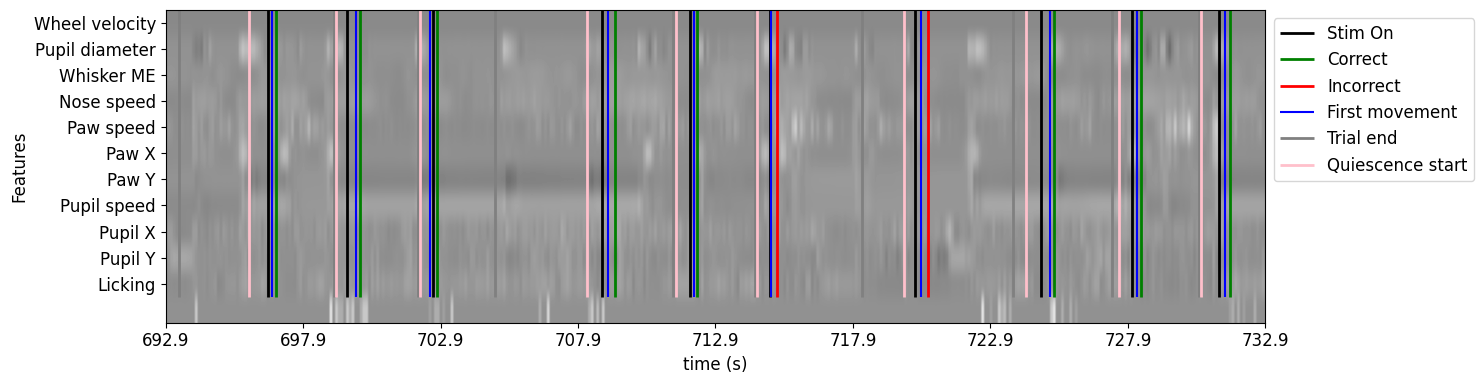

In [31]:
init = 6000
end = init + 400
plt.rc('font', size=12)

fig, axs = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(15, 4))

cmap = plt.cm.gray
use_data = scaler.fit_transform(X)
im1 = axs.imshow(use_data.transpose(), aspect='auto', cmap=cmap)  # [:, init:end]
bin_init = design_matrix['Bin'][0]


axs.vlines(np.array(session_trials['goCueTrigger_times'] * 10 - bin_init),-0.5, 10.5, label='Stim On', color='Black', linewidth=2)
axs.vlines(np.array(session_trials.loc[session_trials['feedbackType']==1, 'feedback_times'] * 10 - bin_init), -0.5, 10.5, label='Correct', color='Green', linewidth=2)
axs.vlines(np.array(session_trials.loc[session_trials['feedbackType']==-1, 'feedback_times'] * 10 - bin_init), -0.5, 10.5, label='Incorrect', color='Red', linewidth=2)
axs.vlines(np.array(session_trials['firstMovement_times'] * 10 - bin_init), -0.5, 10.5, label='First movement', color='Blue')
axs.vlines(np.array(session_trials['intervals_0'] * 10 - bin_init), -0.5, 10.5, label='Trial end', color='Grey', linewidth=2)
axs.vlines(np.array((session_trials['goCueTrigger_times'] - session_trials['quiescencePeriod']) * 10 - bin_init), -0.5, 10.5, label='Quiescence start', color='Pink', linewidth=2)
#axs.set_ylim(0, 1)

axs.set_ylabel("Features")
axs.set_xlabel("time (s)")
axs.set_xlim(init, end)
axs.set_xticks(np.arange(init, end+50, 50),np.arange((init+bin_init)/10, (end+bin_init)/10+5, 5))
feature_names = ['Wheel velocity', 'Pupil diameter', 'Whisker ME', 'Nose speed', 'Paw speed', 'Paw X', 'Paw Y', 'Pupil speed', 'Pupil X', 'Pupil Y', 'Licking']
axs.set_yticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], feature_names)
axs.legend(loc='upper left', bbox_to_anchor=(1, 1))
cbar1 = fig.colorbar(im1, ax=ax)

plt.tight_layout()
plt.show()

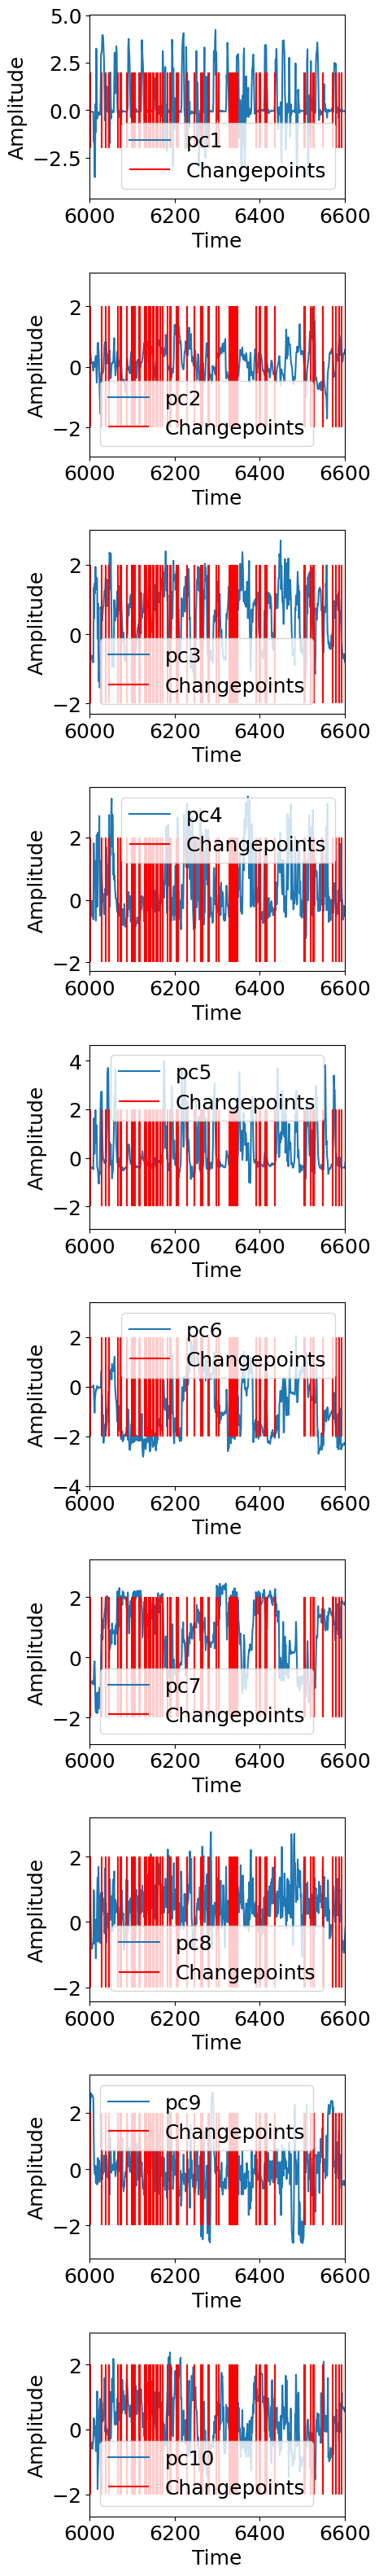

In [296]:
derivative = augmented_data.copy()
pcs = augmented_data.keys()[1:]

min = 6000
max = min + 600

fig, ax = plt.subplots(nrows=len(pcs) , ncols=1, sharex=False, sharey=False, figsize=[5, 32])

for i, pc in enumerate(pcs):
    
    #time = augmented_data['Bin']
    time = np.arange(0, len(augmented_data['Bin']), 1)
    # Plot the time series and local maxima
    ax[i].plot(time, augmented_data[pc], label=pc)
    ax[i].vlines(data_changepoints, -2, 2, color='red', label='Changepoints')
    ax[i].legend()
    ax[i].set_xlabel('Time')
    ax[i].set_ylabel('Amplitude')
    ax[i].set_xlim([min, max])
    
plt.tight_layout()
